In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from utils.arch.anomalies import shock_mean_fn, shock_volatility_fn, perturbed_mean_fn, increasing_volatility_fn, constant_mean
from utils.simulate_markov import simulate_arch_1_process, simulate_arch1_process_with_dynamic_anomaly
from utils.markov_depth import calculate_markov_tukey_depth_for_trajectories_using_long_trajectory
from utils.roc_curves import plot_roc_curve

In [2]:
# Set up the Seaborn style
sns.set(style="whitegrid")

In [3]:
# Fix the random seed for reproducibility 
random_seed = 7
np.random.seed(random_seed)

In [4]:
# Max Number of steps on each trajectory
n_steps = 200
min_n_steps = 50
# Number of steps of the initial long trajectory.
# Used for the initial kernel estimation.
n_steps_long = n_steps*5
# Number of normal trajectories to simulate
M = 100
# Number of anomalous trajectories to simulate
A = 100

# Size of the chock
ANOMALY_SHOCK_SIZE = 2
# Size of the anomalous part (percent of the total length)
ANOMALY_SIZE = 0.75

# Bandwidth parameter for the kernel estimation
inverse_bandwidth = np.power(n_steps_long, 1/5)

In [5]:
# Parameters of the ARCH(1) process
INITIAL_VALUE = 0.5

def mean_fn(x):
    return 1 / (1 + np.exp(-x))

def volatility_fn(x):
    return norm.pdf(x + 1.2) + 1.5 * norm.pdf(x - 1.2)

In [6]:
# Simulate a long ARCH(1) process, used to estimate the kernel
random_seed +=1
long_arch_trajectory = simulate_arch_1_process(
    n_steps=n_steps_long, 
    m=mean_fn, 
    sigma=volatility_fn, 
    initial_value=INITIAL_VALUE, 
    num_processes=1,
    seed=random_seed
)[0]

In [7]:
# Simulate  ARCH(1) processes
random_seed +=1
regular_arch_trajectories = simulate_arch_1_process(
    n_steps=n_steps, 
    m=mean_fn, 
    sigma=volatility_fn, 
    initial_value=INITIAL_VALUE, 
    num_processes=M, 
    min_n_step=min_n_steps,
    seed=random_seed,
)

## Model 1 (Shock anomalies)

In [8]:
# Simulate anomalous ARCH(1) process of varying length
random_seed +=1
anomalous_shock_arch_trajectories = simulate_arch1_process_with_dynamic_anomaly(
    n_steps=n_steps, 
    m=mean_fn, 
    sigma=volatility_fn, 
    anomalous_m=shock_mean_fn,
    anomalous_sigma=shock_volatility_fn,
    initial_value=INITIAL_VALUE, 
    num_processes=A, 
    anomaly_size=ANOMALY_SHOCK_SIZE,
    seed=random_seed,
    min_n_step=min_n_steps,
)

/Users/carlos/work/Post-Doc/Statistical depth/depth_markov/utils/arch/anomalies.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(x)


In [9]:
regular_arch_depths = calculate_markov_tukey_depth_for_trajectories_using_long_trajectory(trajectories=regular_arch_trajectories, long_trajectory=long_arch_trajectory, inverse_bandwidth=inverse_bandwidth)

In [10]:
anomalous_shock_arch_depths = calculate_markov_tukey_depth_for_trajectories_using_long_trajectory(trajectories=anomalous_shock_arch_trajectories, long_trajectory=long_arch_trajectory, inverse_bandwidth=inverse_bandwidth)

/Users/carlos/work/Post-Doc/Statistical depth/depth_markov/utils/kernel_estimation.py:89: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(K * L) / denominator
/Users/carlos/work/Post-Doc/Statistical depth/depth_markov/utils/kernel_estimation.py:89: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(K * L) / denominator
/Users/carlos/work/Post-Doc/Statistical depth/depth_markov/utils/kernel_estimation.py:89: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(K * L) / denominator
/Users/carlos/work/Post-Doc/Statistical depth/depth_markov/utils/kernel_estimation.py:89: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(K * L) / denominator
/Users/carlos/work/Post-Doc/Statistical depth/depth_markov/utils/kernel_estimation.py:89: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(K * L) / denominator
/Users/carlos/work/Post-Doc/Statistical depth/depth_markov/utils/kerne

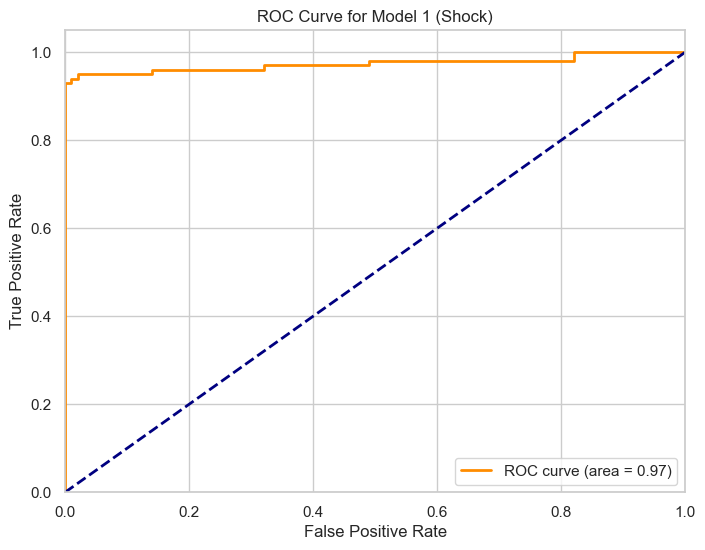

In [11]:
# Because we are labeling regular trajectories as False and anomalous as True,
# and our depth function should be smaller for anomalies, we are using 1-depth 
# for classification.
labels = np.concatenate((np.zeros(M, dtype=bool), np.ones(A, dtype=bool)))
depth_values = np.concatenate((1-regular_arch_depths, 1-anomalous_shock_arch_depths))

plot_roc_curve(labels=labels, values=depth_values, title="ROC Curve for Model 1 (Shock)")
plt.show()

## Model 2 (Perturbed mean)

In [12]:
# Simulate anomalous process
random_seed +=1
anomalous_perturbed_mean_arch_trajectories = simulate_arch1_process_with_dynamic_anomaly(
    n_steps=n_steps, 
    m=mean_fn, 
    sigma=volatility_fn, 
    anomalous_m=perturbed_mean_fn,
    anomalous_sigma=volatility_fn,
    initial_value=INITIAL_VALUE, 
    num_processes=A,
    seed=random_seed,
    min_n_step=min_n_steps,
    anomaly_size=ANOMALY_SIZE,
)

In [13]:
anomalous_perturbed_mean_arch_depths = calculate_markov_tukey_depth_for_trajectories_using_long_trajectory(trajectories=anomalous_perturbed_mean_arch_trajectories, long_trajectory=long_arch_trajectory, inverse_bandwidth=inverse_bandwidth)

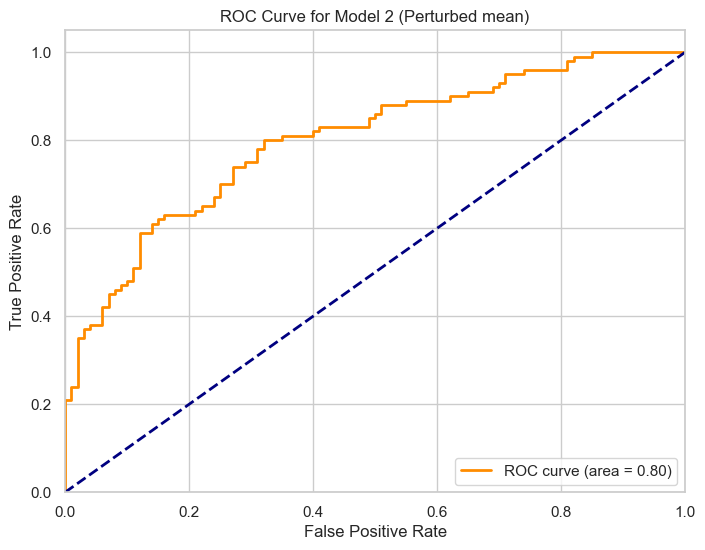

In [14]:
# Because we are labeling regular trajectories as False and anomalous as True,
# and our depth function should be smaller for anomalies, we are using 1-depth 
# for classification.
labels = np.concatenate((np.zeros(M, dtype=bool), np.ones(A, dtype=bool)))
depth_values = np.concatenate((1-regular_arch_depths, 1-anomalous_perturbed_mean_arch_depths))

plot_roc_curve(labels=labels, values=depth_values, title="ROC Curve for Model 2 (Perturbed mean)")
plt.show()

## Model 3 (increasing volatility)

In [15]:
# Simulate anomalous process
random_seed +=1
anomalous_increasing_volatility_arch_trajectories = simulate_arch1_process_with_dynamic_anomaly(
    n_steps=n_steps, 
    m=mean_fn, 
    sigma=volatility_fn,
    anomalous_m=mean_fn,
    anomalous_sigma=increasing_volatility_fn,
    initial_value=INITIAL_VALUE, 
    num_processes=A,
    seed=random_seed,
    min_n_step=min_n_steps,
    anomaly_size=ANOMALY_SIZE,
)

In [16]:
anomalous_increasing_volatility_arch_depths = calculate_markov_tukey_depth_for_trajectories_using_long_trajectory(trajectories=anomalous_increasing_volatility_arch_trajectories, long_trajectory=long_arch_trajectory, inverse_bandwidth=inverse_bandwidth)

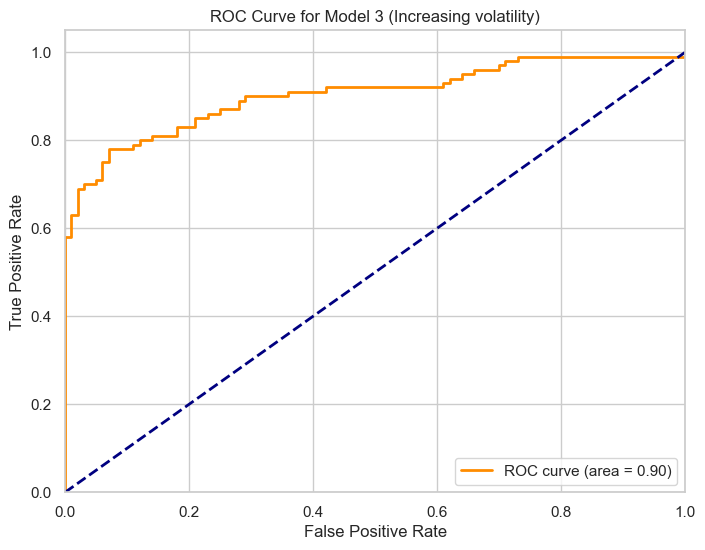

In [17]:
# Because we are labeling regular trajectories as False and anomalous as True,
# and our depth function should be smaller for anomalies, we are using 1-depth 
# for classification.
labels = np.concatenate((np.zeros(M, dtype=bool), np.ones(A, dtype=bool)))
depth_values = np.concatenate((1-regular_arch_depths, 1-anomalous_increasing_volatility_arch_depths))

plot_roc_curve(labels=labels, values=depth_values, title='ROC Curve for Model 3 (Increasing volatility)')
plt.show()

## Model 4 (Deterministic mean)

In [18]:
# Simulate anomalous process
random_seed +=1
anomalous_constant_mean_arch_trajectories = simulate_arch1_process_with_dynamic_anomaly(
    n_steps=n_steps, 
    m=mean_fn, 
    sigma=volatility_fn, 
    anomalous_m=constant_mean,
    anomalous_sigma=volatility_fn,
    initial_value=INITIAL_VALUE, 
    num_processes=A,
    seed=random_seed,
    min_n_step=min_n_steps,
    anomaly_size=ANOMALY_SIZE,
)

In [19]:
anomalous_constant_mean_arch_depths = calculate_markov_tukey_depth_for_trajectories_using_long_trajectory(trajectories=anomalous_constant_mean_arch_trajectories, long_trajectory=long_arch_trajectory, inverse_bandwidth=inverse_bandwidth)

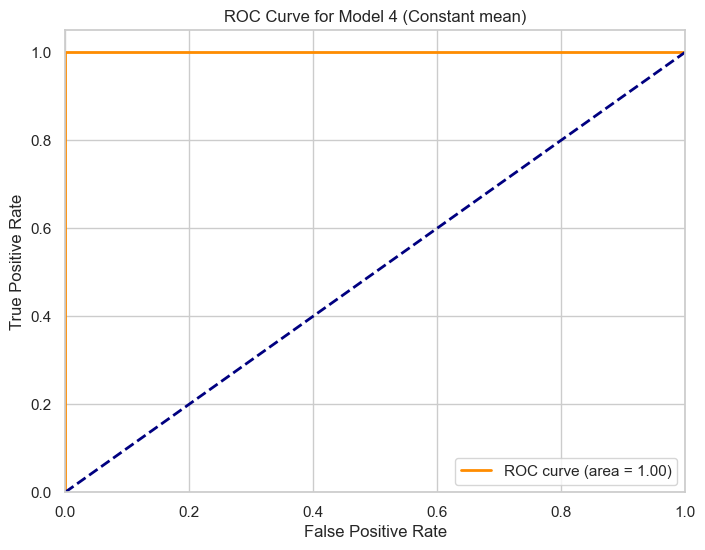

In [20]:
# Because we are labeling regular trajectories as False and anomalous as True,
# and our depth function should be smaller for anomalies, we are using 1-depth 
# for classification.
labels = np.concatenate((np.zeros(M, dtype=bool), np.ones(A, dtype=bool)))
depth_values = np.concatenate((1-regular_arch_depths, 1-anomalous_constant_mean_arch_depths))

plot_roc_curve(labels=labels, values=depth_values, title='ROC Curve for Model 4 (Constant mean)')
plt.show()